Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Tutorial 1  "
COLLABORATORS = "Aakash Rajpal"

---

In [2]:
import sys
import math
import typing
from typing import Tuple, Dict, List

import gensim
import numpy as np
import pandas as pd
import scipy.special

from ast import literal_eval

print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


## 1. Hyperparameters


In [3]:
K = 5 # Number of mixture components
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [4]:
df = pd.read_csv('../../tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)

In [5]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [6]:
dictionary = gensim.corpora.Dictionary(X_tokens)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

print(dictionary)

Dictionary(120 unique tokens: ['look', 'peopl', 'woman', 'love', 'work']...)


### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

Now we apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result is a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [7]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        
    keep_tweet.append(len(tweet_bow) > 1)

df_data = df[keep_tweet]

N = len(df_data)

X_bow[:5]

[[(0, 1), (1, 1), (2, 1)],
 [(6, 1), (7, 1)],
 [(3, 2), (9, 1)],
 [(10, 1), (11, 1)],
 [(11, 1), (12, 1), (13, 1), (14, 1)]]

Finally, we transform the BoW representation `X_bow` into a matrix, `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [8]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]
        
print(X_matrix)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]]


## 3. Categorical Mixture Model with Expectation Maximization

### Exercise 1: Analytical forms of the E and M steps for the EM-Algorithm
1. Write the joint distribution: $p(\{\mathbf{x}_n, z_n\}| \Theta) = \dots$
2. Write the analytical expression for $Q(\Theta, \Theta^{\text{old}}) = \dots$
3. Write the MLE for $\Theta$.

1.

$p(\{\mathbf{x}_n, z_n\}| \Theta) = \dots$

YOUR ANSWER HERE

\begin{aligned}
l_{c}\left(\boldsymbol{\pi},\left\{\boldsymbol{\theta}_{k}\right\}\right) &=\log p\left(\left\{\mathbf{x}_{n}\right\}_{n=1}^{N}, \mathbf{z} \mid \boldsymbol{\pi},\left\{\boldsymbol{\theta}_{k}\right\}\right)=\sum_{n=1}^{N} \log \left(p\left(\mathbf{x}_{n} \mid z_{n},\left\{\boldsymbol{\theta}_{k}\right\}\right) p\left(z_{n} \mid \boldsymbol{\pi}\right)\right)=\sum_{n=1}^{N} \log \left(\prod_{k=1}^{K}\left(p\left(z_{n}=k\right) p\left(\mathbf{x}_{n} \mid \boldsymbol{\theta}_{k}\right)\right)^{\left[z_{n}=k\right]}\right) \\
&=\sum_{n=1}^{N} \log \left(\prod_{k=1}^{K}\left(\pi_{k} p\left(\mathbf{x}_{n} \mid \boldsymbol{\theta}_{k}\right)\right)^{\left[z_{n}=k\right]}\right)=\sum_{n=1}^{N} \sum_{k=1}^{K}\left[z_{n}=k\right] \log \left(\pi_{k} p\left(\mathbf{x}_{n} \mid \boldsymbol{\theta}_{k}\right)\right)
\end{aligned}

Re-Writing hte Expression for $p\left(\mathbf{x}_{n} \mid \boldsymbol{\theta}_{k}\right)=\prod_{j=1}^{W_{n}} \operatorname{Cat}\left(x_{n j} \mid \boldsymbol{\theta}_{k}\right)$

$\begin{aligned} l_{c}\left(\boldsymbol{\pi},\left\{\boldsymbol{\theta}_{k}\right\}\right) &=\sum_{n=1}^{N} \sum_{k=1}^{K}\left[z_{n}=k\right] \log \left(\pi_{k} \prod_{j=1}^{W_{n}} \operatorname{Cat}\left(x_{n j} \mid \boldsymbol{\theta}_{k}\right)\right)=\sum_{n=1}^{N} \sum_{k=1}^{K}\left[z_{n}=k\right] \log \left(\pi_{k} \prod_{j=1}^{W_{n}} \prod_{m=1}^{I} \theta_{k m}^{\left[x_{n j}=m\right]}\right) \\ &=\sum_{n=1}^{N} \sum_{k=1}^{K}\left[z_{n}=k\right] \log \left(\pi_{k}\right)+\sum_{n=1}^{N} \sum_{k=1}^{K} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I}\left[z_{n}=k\right] \log \left(\theta_{k m}^{\left[x_{n} j=m\right]}\right) \end{aligned}$

Now expression of the complete data log-likelihood is

$l_{c}\left(\pi,\left\{\boldsymbol{\theta}_{k}\right\}\right)=\sum_{n=1}^{N} \sum_{k=1}^{K}\left[z_{n}=k\right] \log \left(\pi_{k}\right)+\sum_{n=1}^{N} \sum_{k=1}^{K} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I}\left[z_{n}=k\right]\left[x_{n j}=m\right] \log \left(\theta_{k m}\right)$



2.

$Q(\Theta, \Theta^{\text{old}}) = \dots$

YOUR ANSWER HERE

$Q\left(\theta, \theta^{\mathrm{old}}\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} E\left[\left[z_{n}=k\right]\right] \log \left(x_{k}\right)+\sum_{n=1}^{N} \sum_{k=1}^{K} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I} E\left[\left[z_{n}=k\right]\right]\left[x_{n j}=m\right] \log \left(\theta_{k m}\right)$

Computing $$
E\left\|_{n}=k\right\|=p\left(z_{n}=k \mid \mathbf{x}_{n}, \boldsymbol{\theta}^{\text {old }}\right)
$$ using Bayes THeorem

$$
p\left(z_{n}=k \mid \mathbf{x}_{n}, \boldsymbol{\theta}^{\text {old }}\right)=\frac{p\left(z_{n}=k, \mathbf{x}_{n} \mid \boldsymbol{\theta}^{\text {old }}\right)}{p\left(\mathbf{x}_{n} \mid \boldsymbol{\theta}^{\text {old }}\right)}=\frac{\pi_{k} \prod_{j=1}^{W_{n}} \operatorname{Cat}\left(x_{n j} \mid \boldsymbol{\theta}_{k}\right)}{\sum_{k^{\prime}=1}^{K} \pi_{k^{\prime}} \prod_{j=1}^{W_{n}} \operatorname{Cat}\left(x_{n j} \mid \boldsymbol{\theta}_{k^{\prime}}\right)}=r_{n k}
$$

Complete data log-likelihood

$$
Q\left(\theta, \theta^{\mathrm{old}}\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \log \left(\pi_{k}\right)+\sum_{n=1}^{N} \sum_{k=1}^{K} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I} r_{n k}\left[x_{n j}=m\right] \log \left(\theta_{k m}\right)
$$

Taking $$ r_{n k}$$ outside ans summing $$ x_{n j}$$

$$
\left.Q\left(\theta, \theta^{\text {old }}\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \log \left(\pi_{k}\right)+\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I} \mid x_{n j}=m\right] \log \left(\theta_{k m}\right)
$$


3. 


$\pi^{ML} = \dots$

$\theta^{ML} = \dots$.

To find $\pi^{ML}$ we need to consider Langrange multiplier with condition $\sum_{k} \pi_k = 1$\
Hence we need to find $\frac{dQ(\theta, \theta^{old})}{d\pi_{k}} = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \log (\pi_{k})+\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I} [x_{n j}=m] \log (\theta_{k m})  + \lambda(\sum_{k} \pi_{k} - 1) $

$\frac{dQ(\theta, \theta^{old})}{d\pi_{k}} = \sum_{n=1}^{N} \frac{r_{nk}}{\pi_{k}} + \lambda$

Now considering $\frac{dQ(\theta, \theta^{old})}{d\pi_{k}} = 0 $\
$\sum_{n=1}^{N} \frac{r_{nk}}{-\lambda} = \pi_{k}$\
Now applying the the condition $\sum_{k} \pi_{k} = 1$\
Hence we get $ - \lambda = \sum_{k} \sum_{n} r_{nk}$

So we get $\pi_{k}^{ML} = \frac{\sum_{n} r_{nk}}{\sum_{k} \sum_{n} r_{nk}}$

In a similar manner to find $\theta^{ML}$ we need to consider the condition that $\sum_{m}\theta_{km} = 1$

Hence we need to find $\frac{dQ(\theta, \theta^{old})}{d\theta_{km}} = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \log (\pi_{k})+\sum_{n=1}^{N} \sum_{k=1}^{K} r_{n k} \sum_{j=1}^{W_{n}} \sum_{m=1}^{I} [x_{n j}=m] \log (\theta_{k m})  + \lambda(\sum_{m}\theta_{km} - 1) $

$\frac{dQ(\theta, \theta^{old})}{d\theta_{km}} = \sum_{n=1}^{N} r_{nk} \sum_{j} \frac{[X_{nj} = m]}{\theta_{km}} + \lambda$\
Now considering $\frac{dQ(\theta, \theta^{old})}{d\theta_{km}} = 0 $\
$\sum_{n=1}^{N} r_{nk} \sum_{j} \frac{[X_{nj} = m]}{-\lambda} = \theta_{km}$

Now applying the the condition $\sum_{m}\theta_{km} = 1$\
Hence we get $ - \lambda = \sum_{m} \sum_{n} r_{nk} \sum_{j} [X_{nj} = m] $

So we get $\theta_{km}^{ML} = \frac{\sum_{n} r_{nk} \sum_{j} [X_{nj} = m]}{\sum_{m} \sum_{n} r_{nk} \sum_{j} [X_{nj} = m]}$








In [9]:
np.random.seed(1234)
pi_vector = 1 / K * np.ones([1, K])
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]
z_matrix_index = np.random.choice(K, size=N)
z_matrix =np.eye(K)[z_matrix_index]  

We provide you with the implementation of the  log likelihood function $p(X| \Theta$)

In [10]:
def log_p_x(X, pi_vector, theta_matrix, agg=True):
    """
    log p(x|theta) as in the first equation of the tutorial script
    """
    log_pi_vector = np.log(pi_vector)
    log_x_nk = np.einsum('ni,ki->nk', X, np.log(theta_matrix))
    if agg:
        return scipy.special.logsumexp(log_pi_vector + log_x_nk, axis=1).sum()
    else:
        return scipy.special.logsumexp(log_pi_vector + log_x_nk, axis=1)

#### Exercise 1.1

In [11]:
def log_p(X_matrix, z_matrix, pi_vector, theta_matrix) -> float:
    '''
    Function that returns the value of the log joint distribution $\log p(\{\mathbf{x}_n, z_n\}| \Theta)
    
    :param X_matrix: NxI
    :param z_matrix: NxK. One hot encoding
    :param pi_vector: 1xK
    :param theta_matrix: KxI
    '''
    log_pi = np.log(pi_vector)
    log_like = (z_matrix * log_pi).sum()
    log_theta = np.log(theta_matrix)
    for n in range(N):
        z_n = np.argmax(z_matrix[n])
        for i in range(I):
            log_like += X_matrix[n][i] * log_theta[z_n][i]            
    return log_like

In [12]:
pi_vector = 1 / K * np.ones([1, K])

np.random.seed(1234)
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]
z_matrix_index = np.random.choice(K, size=N)
z_matrix =np.eye(K)[z_matrix_index]  

log_lik = log_p(X_matrix, z_matrix, pi_vector, theta_matrix)

assert math.isclose(log_lik, -128901.37, rel_tol=1e-9, abs_tol=0.1)


#### Exercise 1.2

In [13]:
def compute_lset(ns):
    return scipy.special.logsumexp(ns)

In [14]:
def RIK_matrix(X, pi_vector, theta_matrix) -> np.array:
    r_matrix = np.zeros((N, theta_matrix.shape[0]))
    for n in range(N):
        for k in range(theta_matrix.shape[0]):
            temp = theta_matrix[k]**X[n]
            r_matrix[n][k] = temp.prod() * pi_vector[0][k]
        r_matrix[n] = r_matrix[n] / r_matrix[n].sum() 
    return r_matrix

In [15]:
def Q_function(X, pi_vector, theta_matrix, r_matrix) -> float:
    Q = 0
    log_pi = np.log(pi_vector)
    log_theta = np.log(theta_matrix)
    for n in range(N):
        for k in range(theta_matrix.shape[0]):
            Q += r_matrix[n][k] * log_pi[0][k]
    for n in range(N):
        for k in range(theta_matrix.shape[0]):
            temp = X[n] * log_theta[k]
            Q += temp.sum() * r_matrix[n][k]
            
    return Q

In [16]:
pi_vector = 1 / K * np.ones([1, K])

np.random.seed(1234)
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]
r_matrix = RIK_matrix(X_matrix, pi_vector, theta_matrix)
print(f"Q: {Q_function(X_matrix, pi_vector, theta_matrix, r_matrix)}")

Q: -114981.98506364766


In [17]:
pi_vector = 1 / K * np.ones([1, K])

np.random.seed(1234)
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]
r_matrix = RIK_matrix(X_matrix, pi_vector, theta_matrix)
Q_value = Q_function(X_matrix, pi_vector, theta_matrix, r_matrix)

assert math.isclose(Q_value, -114981.98,  abs_tol=0.1)

    

#### Exercise 1.3

In [18]:
def pi_vector_MLE(X, pi_vector, theta_matrix) -> np.array:
    r_matrix = RIK_matrix(X_matrix, pi_vector, theta_matrix)
    n_k = np.sum(r_matrix, axis = 0)
    return n_k / n_k.sum()

def theta_matrix_MLE(X, pi_vector, theta_matrix) -> np.array:
    r_matrix = RIK_matrix(X_matrix, pi_vector, theta_matrix)
    theta_matrix_mle = np.zeros((theta_matrix.shape[0], I))
    for k in range(theta_matrix.shape[0]):
        for i in range(I):
            temp = r_matrix[:, k] * X[:, i]
            theta_matrix_mle[k][i] = temp.sum()
            
    for k in range(theta_matrix.shape[0]):
        theta_matrix_mle[k] = theta_matrix_mle[k] / theta_matrix_mle[k].sum()
    
    
    return theta_matrix_mle
    

In [19]:
pi_vector = 1 / K * np.ones([1, K])

np.random.seed(1234)
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]
print(f"pi_vector_MLE: {pi_vector_MLE(X_matrix, pi_vector, theta_matrix)}")
print(f"theta_matrix_MLE shape: {theta_matrix_MLE(X_matrix, pi_vector, theta_matrix).shape}")

pi_vector_MLE: [0.2241954  0.23099895 0.13875986 0.23948765 0.16655814]
theta_matrix_MLE shape: (5, 120)


In [20]:
pi_vector = 1 / K * np.ones([1, K])

np.random.seed(1234)
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]


pi_vector_h = pi_vector_MLE(X_matrix, pi_vector, theta_matrix)
theta_matrix_h = theta_matrix_MLE(X_matrix, pi_vector, theta_matrix)


pi_vector_true = [0.2241954,  0.23099895, 0.13875986, 0.23948765, 0.16655814]
theta_matrix_dim_0_true = [0.00962201, 0.03075357, 0.00012886, 0.01882288, 0.00776862]
assert all([ math.isclose(i,j ,abs_tol=0.01) for i, j in zip (pi_vector_h,pi_vector_true)])
assert all([ math.isclose(i,j ,abs_tol=0.01) for i, j in zip (theta_matrix_h[:,0] ,theta_matrix_dim_0_true)])



### Exercise 2: Implement the EM-Algorithm for the CMM  on Twitter data
#### Exercise 2.1

In [21]:

def BIC(log_like, K, I, N) -> float:
    bic = (K + I * K) * np.log(N) - 2 * log_like 
    return bic

def AIC(log_like, K, I) -> float:
    aic = 2 * (K + I * K) - 2 * log_like
    return aic

In [22]:
pi_vector = 1 / K * np.ones([1, K])

np.random.seed(1234)
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]

log_lik = log_p_x(X_matrix, pi_vector, theta_matrix)
bic = BIC(log_lik, K, I, N)
aic = AIC(log_lik, K, I)
print(f"BIC: {bic} AIC: {aic}")

assert  math.isclose(bic, 225766.5360757403, abs_tol=0.1)
assert  math.isclose(aic, 221758.53739852167, abs_tol=0.1)


BIC: 225766.5360757403 AIC: 221758.53739852167


#### Exercise 2.2

In [23]:
def E_step(X, pi_vector, theta_matrix) -> Tuple[np.array, np.array]:
    r_matrix = RIK_matrix(X, pi_vector, theta_matrix)
    Q = Q_function(X, pi_vector, theta_matrix, r_matrix)
    return Q, r_matrix 

In [24]:
def M_step(X, r_matrix) -> Tuple[np.array, np.array]:
    n_k = np.sum(r_matrix, axis = 0)
    pi_vector = n_k / n_k.sum()
    theta_matrix = np.zeros((r_matrix.shape[1], I))
    for k in range(r_matrix.shape[1]):
        for i in range(I):
            temp = r_matrix[:, k] * X[:, i]
            theta_matrix[k][i] = temp.sum()
            
    for k in range(r_matrix.shape[1]):
        theta_matrix[k] = theta_matrix[k] / theta_matrix[k].sum()
    
    return [pi_vector], theta_matrix

#### Exercise 2.3

In [25]:
def fit_CMM(X, theta_matrix_init, pi_vector_init, num_epochs, delta=0.01) -> Tuple[np.array, np.array, list, float, float, int]:
    N, I = X.shape
    K, _ = theta_matrix_init.shape
    
    theta_matrix = theta_matrix_init
    pi_vector = pi_vector_init

    prev_log_px = float('-inf')
    log_px_list = []
    for epoch in range(num_epochs):
        _, r_matrix = E_step(X, pi_vector, theta_matrix)
        pi_vector, theta_matrix = M_step(X, r_matrix)
        log_px = log_p_x(X_matrix, pi_vector, theta_matrix)
        diff = log_px - prev_log_px
        log_px_list.append(log_px)
        prev_log_px = log_px
        if (diff < delta):
            print(f'ITER {str(epoch)}: log_px = {str(np.around(log_px, 4))} diff = {str(np.around(diff, 4))}')
            break
            
        if epoch % 10 == 0:
            print(f'ITER {str(epoch)}: log_px = {str(np.around(log_px, 4))} diff = {str(np.around(diff, 4))}')

    BIC_tr = BIC(log_px_list[-1], K, I, N)
    AIC_tr = AIC(log_px_list[-1],K, I)
    return pi_vector, theta_matrix, log_px_list, BIC_tr, AIC_tr, epoch

In [26]:
K = 5 # Number of mixture components
np.random.seed(1234)
pi_vector = 1 / K * np.ones([1, K])
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]


pi_vector, theta_matrix, log_px_list, BIC_tr, AIC_tr, epoch = fit_CMM(X=X_matrix, 
                                                                  theta_matrix_init=theta_matrix, 
                                                                  pi_vector_init=pi_vector, 
                                                                  num_epochs=100,
                                                                  delta=100)

print(f'Last log_px: {log_px_list[-1]}')
assert math.isclose(log_px_list[-1], -99791.58059258852,abs_tol=100)


ITER 0: log_px = -102684.2752 diff = inf
ITER 10: log_px = -100206.6843 diff = 123.497
ITER 14: log_px = -99791.5806 diff = 96.3235
Last log_px: -99791.58059258852


Text(0, 0.5, '$log p(X|\\Theta)$')

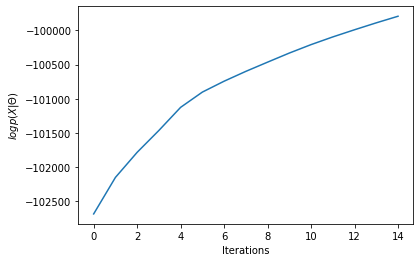

In [27]:
import matplotlib.pyplot as plt
data = plt.plot(log_px_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

#### Exercise 2.4

In [28]:
def find_best_K(K_list, num_epochs, delta) -> Tuple[float, float]:
    res = []
    log_list = []
    for k in K_list:
        pi_vector = 1 / k * np.ones([1, k])
        theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=k)  # [K, I]
        _, _, _, _, AIC_tr, _ = fit_CMM(X = X_matrix, theta_matrix_init = theta_matrix, pi_vector_init=pi_vector,
                                        num_epochs=num_epochs,delta=delta)
        res.append(AIC_tr)
    K_best = res[np.argmin(res)]
    AIC_best = np.min(res)
    return AIC_best, K_best

In [29]:
K_list = [2,5, 10]
AIC_best, K_best =  find_best_K(K_list,  num_epochs=100, delta=100)
print(f"K with best AIC [{AIC_best:.2f}]: {K_best}\n")

ITER 0: log_px = -103012.718 diff = inf
ITER 7: log_px = -101707.9442 diff = 48.5529
ITER 0: log_px = -102687.7737 diff = inf
ITER 10: log_px = -100205.2914 diff = 105.0607
ITER 11: log_px = -100113.0994 diff = 92.192
ITER 0: log_px = -101873.0539 diff = inf
ITER 9: log_px = -98456.3012 diff = 81.5335
K with best AIC [199332.60]: 199332.60245419116



In [30]:
# np.random.seed(1234)
# K_list = [2,5, 10]

# AIC_best, K_best =  find_best_K(K_list,  num_epochs=100, delta=1000)

# print(f"K with best AIC [{AIC_best:.2f}]: {K_best}\n")
# assert  math.isclose(K_best, -42497679.35 ,abs_tol=100)

#### Exercise 2.5

In [31]:
def get_most_likely_words_per_topic(theta_matrix, dictionary, n_words=10) -> Dict[str, List[str]]:
    '''
    Return a dictionary {topic_id: list_of_words}
    '''
    word_dict = {}
    for k in range(K):
        max_indices = theta_matrix[k].argsort()[-n_words:][::-1]
        res = []
        for i in range(n_words):
            res.append(dictionary[max_indices[i]])
        word_dict[str(k)] = res
    return word_dict


def get_most_likely_documents(X_matrix, pi_vector, theta_matrix, n_docs=10) -> Dict[str, List[int]]:
    '''
    Return a dictionary {topic_id: list_of_documents}
    '''
    doc_dict = {}
    for k in range(K):
        like = X_matrix * theta_matrix[k]
        like = np.sum(like, axis = 1)
        like = like * pi_vector[0][k]
        max_indices = like.argsort()[-n_docs:][::-1]
        doc_dict[str(k)] = max_indices.tolist()
    return doc_dict


In [32]:
np.random.seed(1234)
K = 5 # Number of mixture components
np.random.seed(1234)
pi_vector = 1 / K * np.ones([1, K])
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]


pi_vector, theta_matrix, log_px_list, BIC_tr, AIC_tr, epoch = fit_CMM(X=X_matrix, 
                                                                  theta_matrix_init=theta_matrix, 
                                                                  pi_vector_init=pi_vector, 
                                                                  num_epochs=1000,
                                                                  delta=100)
word_list = get_most_likely_words_per_topic(theta_matrix, dictionary, n_words=10)
for topic_id, list_of_words in word_list.items():
    print(f"Topic {topic_id}: {', '.join(list_of_words)}")

doc_list = get_most_likely_documents(X_matrix, pi_vector, theta_matrix, n_docs=10)
for topic_id, list_of_docs in doc_list.items():
    print(f"Topic {topic_id}: {list_of_docs}")
    

ITER 0: log_px = -102684.2752 diff = inf
ITER 10: log_px = -100206.6843 diff = 123.497
ITER 14: log_px = -99791.5806 diff = 96.3235
Topic 0: learn, model, new, research, work, deep, paper, machin, data, train
Topic 1: work, thank, great, look, peopl, today, day, presid, american, democrat
Topic 2: new, time, human, work, book, year, world, patient, better, chang
Topic 3: new, train, complet, net, sha, data, model, set, care, scienc
Topic 4: like, good, know, need, work, data, use, patient, think, look
Topic 0: [1437, 1996, 1457, 2841, 1470, 2835, 1883, 1443, 733, 1427]
Topic 1: [5127, 4800, 3469, 251, 2660, 1680, 4796, 4801, 4799, 2618]
Topic 2: [710, 2694, 11, 3160, 193, 3639, 2846, 4076, 3675, 3998]
Topic 3: [3054, 3088, 3103, 3102, 3101, 3100, 3099, 3098, 3097, 3096]
Topic 4: [1288, 2057, 3150, 2568, 1540, 4479, 3160, 4628, 2694, 197]


In [33]:
np.random.seed(1234)
K = 10 # Number of mixture components
np.random.seed(1234)
pi_vector = 1 / K * np.ones([1, K])
theta_matrix =  np.random.dirichlet(1. * np.ones(I), size=K)  # [K, I]


pi_vector, theta_matrix, log_px_list, BIC_tr, AIC_tr, epoch = fit_CMM(X=X_matrix, 
                                                                  theta_matrix_init=theta_matrix, 
                                                                  pi_vector_init=pi_vector, 
                                                                  num_epochs=1000,
                                                                  delta=100)
word_list = get_most_likely_words_per_topic(theta_matrix, dictionary, n_words=10)
for topic_id, list_of_words in word_list.items():
    print(f"Topic {topic_id}: {', '.join(list_of_words)}")

doc_list = get_most_likely_documents(X_matrix, pi_vector, theta_matrix, n_docs=10)
for topic_id, list_of_docs in doc_list.items():
    print(f"Topic {topic_id}: {list_of_docs}")
    

ITER 0: log_px = -102288.3608 diff = inf
ITER 9: log_px = -98581.3748 diff = 77.0242
Topic 0: peopl, time, presid, like, democrat, trump, work, american, want, think
Topic 1: research, woman, today, student, work, open, new, peopl, need, world
Topic 2: book, new, year, tech, thank, student, read, way, compani, great
Topic 3: health, data, care, patient, new, social, scienc, work, public, time
Topic 4: need, watch, question, like, work, ask, studi, use, know, live
Topic 5: learn, like, know, look, patient, good, machin, read, think, want
Topic 6: thank, great, day, week, look, work, today, time, forward, challeng
Topic 7: learn, model, new, deep, research, train, data, paper, work, base
Topic 8: train, complet, net, new, sha, time, experi, network, work, big
Topic 9: work, learn, new, team, like, look, design, help, paper, interest
Topic 0: [5439, 5258, 5127, 5075, 5057, 5214, 5111, 3424, 2007, 5288]
Topic 1: [676, 1609, 2830, 1664, 2489, 3474, 2794, 11, 2625, 710]
Topic 2: [710, 549, 2